In [1]:
BATCH_SIZE=20
TRAIN_SET_SIZE = 400
VALIDATION_SET_SIZE = 133

STEPS_PER_EPOCH=TRAIN_SET_SIZE // BATCH_SIZE
print(STEPS_PER_EPOCH)

20


Using TensorFlow backend.


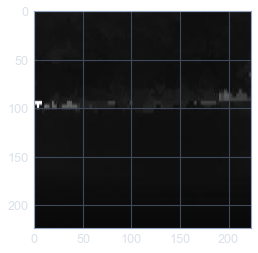

In [2]:
img_path_depth='/Users/mikc/Documents/Datasets/DoF/train/depth/img-stats7-p-344t0.jpg'
img_path_image='/Users/mikc/Documents/Datasets/DoF/train/image/img-stats7-p-344t0.jpg'
from keras.preprocessing import image
import numpy as np
img = image.load_img(img_path_depth, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.0
img2 = image.load_img(img_path_image, target_size=(224, 224))
img_tensor2 = image.img_to_array(img2)
img_tensor2 = np.expand_dims(img_tensor2, axis=0)
img_tensor2 /= 255.0

import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
#plt.imshow(img_tensor2[0])

plt.show()

In [3]:
import os
base_dir='/Users/mikc/Documents/Datasets/DoF/'
train_dir=os.path.join(base_dir, 'train')
train_images_dir = os.path.join(train_dir, 'image')
train_depth_dir = os.path.join(train_dir, 'depth')
validation_dir=os.path.join(base_dir, 'test')
validation_images_dir = os.path.join(validation_dir, 'image')
validation_depth_dir = os.path.join(validation_dir, 'depth')

In [4]:
from keras.applications import VGG16
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Flatten,Dense
from keras.models import Model
from keras.optimizers import RMSprop, Adam

#from keras.applications.vgg16 import VGG16

conv_base = VGG16(
    weights='imagenet',
    input_shape=(224,224,3),
    include_top=False
)



conv_base.summary()

def VGG16_encoder_decoder(input_img, base_model):

    for layer in base_model.layers:
        layer.trainable=False
    
#-------------------encoder---------------------------- 
#--------(pretrained & trainable if selected)----------

#    block1
    x=base_model.get_layer('block1_conv1')(input_img)
    x=base_model.get_layer('block1_conv2')(x)
    x=base_model.get_layer('block1_pool')(x)

#    block2
    x=base_model.get_layer('block2_conv1')(x)
    x=base_model.get_layer('block2_conv2')(x)
    x=base_model.get_layer('block2_pool')(x)

#    block3
    x=base_model.get_layer('block3_conv1')(x)
    x=base_model.get_layer('block3_conv2')(x)
    x=base_model.get_layer('block3_conv3')(x)    
    x=base_model.get_layer('block3_pool')(x)

#    block4
    x=base_model.get_layer('block4_conv1')(x)
    x=base_model.get_layer('block4_conv2')(x)
    x=base_model.get_layer('block4_conv3')(x)    
    x=base_model.get_layer('block4_pool')(x)

#    block5
    x=base_model.get_layer('block5_conv1')(x)
    x=base_model.get_layer('block5_conv2')(x)
    x=base_model.get_layer('block5_conv3')(x)
     
    
#--------latent space (trainable) ------------
    x=base_model.get_layer('block5_pool')(x)     
    x = Conv2D(512, (3, 3), activation='relu', padding='same',name='latent')(x)
    x = UpSampling2D((2,2))(x)  
    
#--------------decoder (trainable)----------- 
        
  # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='dblock5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='dblock5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='dblock5_conv3')(x)
    x = UpSampling2D((2,2))(x)

  # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='dblock4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='dblock4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='dblock4_conv3')(x)
    x = UpSampling2D((2,2))(x)

  # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='dblock3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='dblock3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='dblock3_conv3')(x)
    x = UpSampling2D((2,2))(x)     
     
  # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='dblock2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='dblock2_conv3')(x)
    x = UpSampling2D((2,2))(x)        
 
  # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='dblock1_conv1')(x)
    x = Conv2D(3, (3, 3), activation='relu', padding='same', name='dblock1_conv3')(x)
#    x = UpSampling2D((2,2))(x) 
    
    return x


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
input_image = Input(shape = (224, 224, 3))

autoencoder=Model(input_image, VGG16_encoder_decoder(input_image, conv_base))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())
optimizer='adam', #optimizers.RMSprop(lr=2e-5),
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [6]:
import random
import cv2
import os
import glob
import itertools
from keras.preprocessing import image
#from keras.preprocessing.image.utils import load_img, img_to_array
import numpy as np

def read_image2(img_path, width=224, height=224):
    img = image.load_img(img_path, target_size=(width, height))
    img_tensor = image.img_to_array(img)
    #img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.0
    return img_tensor

def read_image(image, width=224, height=224):
    img = cv2.imread(image, 1)
    img = cv2.resize(img, (width, height))
    img = img.astype(np.float32)
    img = img/255.0
    
    
def get_pairs_from_paths(image_dir, depth_dir):
    image_glob=os.path.join(image_dir, "*jpg")

    image_pairs=[]

    for f in glob.glob(image_glob):
        base = os.path.basename(f)
        depth = os.path.join(depth_dir, base)
        if os.path.exists(depth):
            image_pairs.append((f, depth))


    #random.shuffle(image_pairs)
    return image_pairs
    
    
def image_depth_generator(images_path, segs_path, batch_size=1,
                                 output_height=224, output_width=224,
                                 do_augment=False):

    img_seg_pairs = get_pairs_from_paths(images_path, segs_path)
    random.shuffle(img_seg_pairs)
    zipped = itertools.cycle(img_seg_pairs)

    while True:
        X = []
        Y = []
        for _ in range(batch_size):
            im, seg = next(zipped)
            #print(im)
            #print(seg)
            X.append(read_image2(im, width=output_width, height=output_height))
            Y.append(read_image2(seg, width=output_width, height=output_height))
        #print(np.array(X))
        yield (np.array(X), np.array(Y))

# combine generators into one which yields image and masks
train_generator = image_depth_generator(train_images_dir, train_depth_dir, batch_size=BATCH_SIZE)
validation_generator = image_depth_generator(validation_images_dir, validation_depth_dir, batch_size=BATCH_SIZE)


In [7]:
X=[]
X.append(read_image2('/Users/mikc/Documents/Datasets/DoF/test/image/img-stats7-p-219t0.jpg'))
#X.append(read_image2('/Users/mikc/Documents/Datasets/DoF/test/image/img-op29-p-295t000.jpg'))
X.append(read_image2('/Users/mikc/Documents/Datasets/DoF/train/image/img-10.21op3-p-047t000.jpg'))
X.append(read_image2('/Users/mikc/Documents/Datasets/DoF/train/image/img-10.21op3-p-047t000.jpg'))
for i in range(10):
    print(i)
    next(validation_generator)
    
Z=np.array(X)
Z.shape

0
1
2
3
4
5
6
7
8
9


(3, 224, 224, 3)

In [7]:
#next(train_generator)
from keras.callbacks import ModelCheckpoint
#from keras import optimizers
from keras.models import Sequential
model = Sequential()
filepath="weights-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

hist=autoencoder.fit_generator(
    train_generator,
    steps_per_epoch=TRAIN_SET_SIZE // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=VALIDATION_SET_SIZE // BATCH_SIZE,
    verbose=1,
    
    callbacks=callbacks_list,
    epochs=75)

Epoch 1/75
20/20 [==============================] - 681s 34s/step - loss: 257.5798 - val_loss: 0.1506

Epoch 00001: saving model to weights-01.hdf5
Epoch 2/75
20/20 [==============================] - 695s 35s/step - loss: 0.1247 - val_loss: 0.1125

Epoch 00002: saving model to weights-02.hdf5
Epoch 3/75
20/20 [==============================] - 631s 32s/step - loss: 0.1258 - val_loss: 0.1384

Epoch 00003: saving model to weights-03.hdf5
Epoch 4/75
20/20 [==============================] - 614s 31s/step - loss: 0.1198 - val_loss: 0.1311

Epoch 00004: saving model to weights-04.hdf5
Epoch 5/75
20/20 [==============================] - 605s 30s/step - loss: 0.1191 - val_loss: 0.1440

Epoch 00005: saving model to weights-05.hdf5
Epoch 6/75
20/20 [==============================] - 604s 30s/step - loss: 0.1167 - val_loss: 0.1318

Epoch 00006: saving model to weights-06.hdf5
Epoch 7/75
20/20 [==============================] - 604s 30s/step - loss: 0.1127 - val_loss: 0.1271

Epoch 00007: saving m

Epoch 57/75
20/20 [==============================] - 582s 29s/step - loss: 0.0560 - val_loss: 0.0902

Epoch 00057: saving model to weights-57.hdf5
Epoch 58/75
20/20 [==============================] - 580s 29s/step - loss: 0.0565 - val_loss: 0.0825

Epoch 00058: saving model to weights-58.hdf5
Epoch 59/75
20/20 [==============================] - 579s 29s/step - loss: 0.0565 - val_loss: 0.0664

Epoch 00059: saving model to weights-59.hdf5
Epoch 60/75
20/20 [==============================] - 581s 29s/step - loss: 0.0565 - val_loss: 0.0552

Epoch 00060: saving model to weights-60.hdf5
Epoch 61/75
20/20 [==============================] - 580s 29s/step - loss: 0.0559 - val_loss: 0.0577

Epoch 00061: saving model to weights-61.hdf5
Epoch 62/75
20/20 [==============================] - 579s 29s/step - loss: 0.0550 - val_loss: 0.0908

Epoch 00062: saving model to weights-62.hdf5
Epoch 63/75
20/20 [==============================] - 583s 29s/step - loss: 0.0547 - val_loss: 0.0689

Epoch 00063: sav

In [7]:
autoencoder.load_weights("weights-75.hdf5")

In [9]:
import matplotlib.pyplot as plt
#acc = hist.history['accuracy']
#val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(loss)+1)




AttributeError: 'NoneType' object has no attribute 'history'

<Figure size 432x288 with 0 Axes>

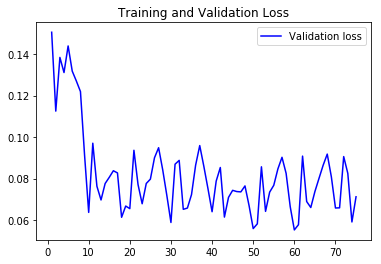

<Figure size 432x288 with 0 Axes>

In [11]:
#plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.figure()

In [8]:
#test_path = '/Users/mikc/Downloads/katri-vinor-02-uprava.jpg'
#test_path = '/Users/mikc/Downloads/katri-vinor-03.jpg'
#test_path = '/Users/mikc/Documents/Datasets/DoF/train/image/img-stats9-p-77t0.jpg'
#test_path = '/Users/mikc/Documents/Datasets/DoF/train/image/img-stats9-p-219t0.jpg'
test_path = '/Users/mikc/Documents/Datasets/DoF/test/image/img-stats9-p-251t0.jpg'
#g_path = '/Users/mikc/Documents/Datasets/DoF/test/depth/img-stats9-p-251t0.jpg'
#test_path = '/Users/mikc/Downloads/20200226_144155.jpg'
#test_image = np.array([read_image2(g_path)])
test_image = np.array([read_image2(test_path)])
test_image.shape

path_prefix='/Users/mikc/Documents/Datasets/DoF/test/image/'


In [9]:
import os
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import Image

@interact
def show_images(file=sorted(os.listdir(path_prefix))):
    display(Image(path_prefix+'/'+file))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnZmlsZScsIG9wdGlvbnM9KCdpbWctMDYwNzA1LTE3LjEwLjE0LXAtMDQ5dDAwMC5qcGcnLCAnaW1nLTA2MDcwNS3igKY=


In [10]:
@interact
def predict_image(file=sorted(os.listdir(path_prefix))):
    test_path = path_prefix+'/'+file
    test_image = np.array([read_image2(test_path)])
    Y=autoencoder.predict(test_image)
    display(Image(test_path))
    plt.imshow(Y[0])



aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnZmlsZScsIG9wdGlvbnM9KCdpbWctMDYwNzA1LTE3LjEwLjE0LXAtMDQ5dDAwMC5qcGcnLCAnaW1nLTA2MDcwNS3igKY=


In [11]:
Y.shape


(1, 224, 224, 3)

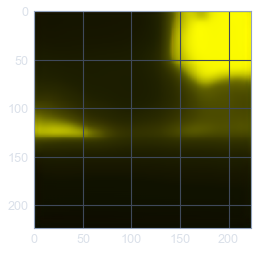

In [12]:
plt.imshow(Y[0])

#plt.imshow(test_image[0])

plt.show()
image.save_img('output.png', Y[0])

In [66]:
import glob
models=[]
for m in glob.glob("*hdf5"):
    models.append(m)
    
models.sort()
img_name="depth-predicted-{0:02d}.png"
i=1
for m in models:
    print(m)
    autoencoder.load_weights(m)
    Y=autoencoder.predict(test_image)
    image.save_img(img_name.format(i), Y[0])
    i+=1

weights-01.hdf5
weights-02.hdf5
weights-03.hdf5
weights-04.hdf5
weights-05.hdf5
weights-06.hdf5
weights-07.hdf5
weights-08.hdf5
weights-09.hdf5
weights-10.hdf5
weights-11.hdf5
weights-12.hdf5
weights-13.hdf5
weights-14.hdf5
weights-15.hdf5
weights-16.hdf5
weights-17.hdf5
weights-18.hdf5
weights-19.hdf5
weights-20.hdf5
weights-21.hdf5
weights-22.hdf5
weights-23.hdf5
weights-24.hdf5
weights-25.hdf5
weights-26.hdf5
weights-27.hdf5
weights-28.hdf5
weights-29.hdf5
weights-30.hdf5
weights-31.hdf5
weights-32.hdf5
weights-33.hdf5
weights-34.hdf5
weights-35.hdf5
weights-36.hdf5
weights-37.hdf5
weights-38.hdf5
weights-39.hdf5
weights-40.hdf5
weights-41.hdf5
weights-42.hdf5
weights-43.hdf5
weights-44.hdf5
weights-45.hdf5
weights-46.hdf5
weights-47.hdf5
weights-48.hdf5
weights-49.hdf5
weights-50.hdf5
weights-51.hdf5
weights-52.hdf5
weights-53.hdf5
weights-54.hdf5
weights-55.hdf5
weights-56.hdf5
weights-57.hdf5
weights-58.hdf5
weights-59.hdf5
weights-60.hdf5
weights-61.hdf5
weights-62.hdf5
weights-

In [54]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='model.png')

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.